分类问题损失函数区分

二分类	sigmoid函数	二分类交叉熵损失函数（binary_crossentropy）

多分类	Softmax函数	多类别交叉熵损失函数（categorical_crossentropy）

多标签分类	sigmoid函数	二分类交叉熵损失函数（binary_crossentropy）

In [1]:
import os
import sys
import time
import sklearn
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

sys.version_info(major=3, minor=7, micro=3, releaselevel='final', serial=0)
matplotlib 3.0.3
numpy 1.16.2
pandas 0.24.2
sklearn 0.20.3
tensorflow 2.0.0-rc0
tensorflow.python.keras.api._v2.keras 2.2.4-tf


In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(55000, 28, 28) (55000,)
(5000, 28, 28) (5000,)
(10000, 28, 28) (10000,)


In [3]:
# 对数据进行归一化处理 x = (x - u) /std

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# x_train 需要做除法，故将其转为 np.float32
# fit_transform 参数为二维矩阵
# x_train: [None, 28, 28 ] -> reshape(-1, 1) 转为二维 ->再转回来 reshape(-1, 28, 28)
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_valid_scaled = scaler.transform(
    x_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_test_scaled = scaler.transform(
    x_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)

# fit_transform 与 transform 区别：
# fit 会记录训练集的均值和方差，
# 验证记和测试集归一化时要用训练集的均值和方差

In [4]:
# relu: y = max(0, x)
# softmax: 将向量变成概率分布。x = [x1, x2, x3],
#          y = [e^x1/sum, e^x2/sum, e^x3/sum, sum=e^x1 + e^x2 + e^x3]

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(300,activation="relu"),
    keras.layers.Dense(100,activation="relu"),
    keras.layers.Dense(10,activation="softmax")
])


# reason for sparse_categorical_crossentropy: y -> index ,即y是单值  y_train[0] = 4
# reason for categorical_crossentropy: y -> one_hot->[] ,即y已经由one_hot转为向量
model.compile(loss = "sparse_categorical_crossentropy", # 损失函数
              optimizer = "adam",                       # 模型的求解方法
              metrics = ["accuracy"])                   # 增加 accuracy 指标

In [5]:
# 查询模型概况
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [6]:
# EarlyStopping   当模型训练loss不再下降时，可用于提前停止训练 
# --  monitor 需要关注哪个指标，一般关注验证集上的目标函数的值
# --  min_delta= 1e-3, # 本次训练与上次训练的差值若低于此阈值，则需停止训练
# --  patience=5, # 连续多少次小于min_delta，则需停止训练

# ModelCheckpoint 每隔一段时间保存中间状态  ---> 需要定义文件名
# TensorBoard     训练过程中就可看数据曲线  ---> 需要定义文件夹


logdir = os.path.join("callbacks")

if not os.path.exists(logdir):
    os.mkdir(logdir)
    
output_model_file = os.path.join(logdir,"fashion_mnist_model.h5")

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file,
                                    save_best_only = True), # 保存最好的模型，默认最新
    keras.callbacks.EarlyStopping(
        min_delta= 1e-3, 
        patience=5, 
    ),
]


history = model.fit(x_train_scaled,y_train,epochs=100,
          validation_data=(x_valid_scaled,y_valid),
          callbacks=callbacks)

Train on 55000 samples, validate on 5000 samples
Epoch 1/100
55000/55000 [==============================] - 6s 117us/sample - loss: 0.4576 - accuracy: 0.8305 - val_loss: 0.4225 - val_accuracy: 0.8484
Epoch 2/100
55000/55000 [==============================] - 5s 93us/sample - loss: 0.3498 - accuracy: 0.8706 - val_loss: 0.3469 - val_accuracy: 0.8762
Epoch 3/100
55000/55000 [==============================] - 5s 89us/sample - loss: 0.3143 - accuracy: 0.8813 - val_loss: 0.3529 - val_accuracy: 0.8698
Epoch 4/100
55000/55000 [==============================] - 5s 91us/sample - loss: 0.2908 - accuracy: 0.8916 - val_loss: 0.3047 - val_accuracy: 0.8902
Epoch 5/100
55000/55000 [==============================] - 5s 90us/sample - loss: 0.2723 - accuracy: 0.8971 - val_loss: 0.3155 - val_accuracy: 0.8872
Epoch 6/100
55000/55000 [==============================] - 5s 90us/sample - loss: 0.2580 - accuracy: 0.9028 - val_loss: 0.3072 - val_accuracy: 0.8900
Epoch 7/100
55000/55000 [=========================

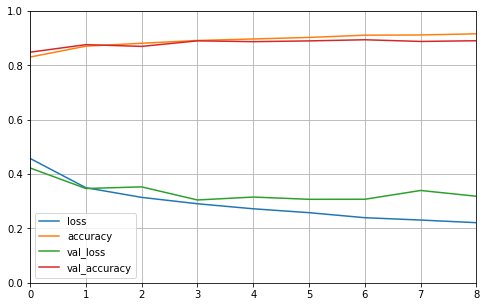

In [7]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()

plot_learning_curves(history)

In [8]:
model.evaluate(x_test_scaled,y_test)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.3603144079566002, 0.8784]

In [ ]:
# 打开tensorflow Tensorboard 
!tensorboard --logdir=callbacks

In [ ]:
# http://localhost:6006/